# Baseline 
Baseline solution for VarDial 2022 shared task on Italian Dialect Classification. 

In [1]:
# load the dataset
import pandas as pd
data = pd.read_csv("dataset/data.csv", ) 

In [2]:
data.head() 

,id,url,title,text,label,clean
0,32636.0,https://eml.wikipedia.org/wiki?curid=32636,.iveco,'l è 'l nòm 'd un domìni genèric. Al funsiòun...,0.0,'l è 'l nòm 'd un domìni genèric. Al funsiòun...
1,32637.0,https://eml.wikipedia.org/wiki?curid=32637,.case,'l è 'l nòm 'd un domìni genèric. Al funsiòun...,0.0,'l è 'l nòm 'd un domìni genèric. Al funsiòun...
2,32638.0,https://eml.wikipedia.org/wiki?curid=32638,.caseih,'l è 'l nòm 'd un domìni genèric. Al funsiòun...,0.0,'l è 'l nòm 'd un domìni genèric. Al funsiòun...
3,32639.0,https://eml.wikipedia.org/wiki?curid=32639,.baseball,'l è 'l nòm 'd un domìni genèric. Al funsiòun...,0.0,'l è 'l nòm 'd un domìni genèric. Al funsiòun...
4,32640.0,https://eml.wikipedia.org/wiki?curid=32640,.newholland,'l è 'l nòm 'd un domìni genèric. Al funsiòun...,0.0,'l è 'l nòm 'd un domìni genèric. Al funsiòun...


In [3]:
X = data['clean'].values
y = data['label'].values.astype(int)
print(X.shape, y.shape)

(264972,) (264972,)


Vectorize and scale the training data.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=100000)
scaler = StandardScaler(with_mean=False)
X = vectorizer.fit_transform(X)
X = scaler.fit_transform(X)

In [5]:
X.shape

(264972, 100000)

Cross-validation k-fold cross validation initialization.

In [6]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

Train a naive Bayes classifier with the extracted features.

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

model = SGDClassifier(max_iter=7000)
scores = cross_val_score(model, X, y, scoring='f1_micro', cv=rkf, n_jobs=-1)
print(f'Repeated cross-validation scores: {np.mean(scores)} ({np.std(scores)})')

Repeated cross-validation scores: 0.9966310910741057 (0.0001842181220778996)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [9]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# from utils import explain_label

# vocab = vectorizer.get_feature_names_out()

# for label in data['label'].unique():
#     slicer = y_train == label
#     f = X_train[slicer]
#     total_freqs = list(np.array(f.sum(axis=0))[0])
#     fdict = dict(zip(vocab,total_freqs))
#     # generate word cloud of words with highest counts
#     wordcloud = WordCloud().generate_from_frequencies(fdict) 
#     print(explain_label(label=label))
#     plt.clf()
#     plt.imshow(wordcloud, interpolation='bilinear') 
#     plt.axis("off") 
#     plt.show()

## Evaluation 

Import devset.

In [6]:
from utils import encode_label

data = pd.read_csv("dataset/dev.txt", sep = "\t", names=["label", "sample"])
data['label'] = data['label'].apply(encode_label)
data.head(10)

,label,sample
0,6,"Ma te see foeura de coo, ò te me toeuvet in gir?."
1,8,a carni re puvireddi.
2,6,L'era on simpatich tradizional appontament con...
3,9,Chi un tenpo xè stà zovane adesso se consola b...
4,5,"ma òua scià no coménse a fâse do mâ da sôlo, a..."
5,8,"ti lassai sula, comu na varca senza vela, a te..."
6,8,Nun savi 'a sacrificari nenti.
7,8,Na notti chi û senti passari sutta i so
8,9,Da seno a mi me par Che no ghe sia rason de ba...
9,3,Lis ruedis di fat a corevin dentri de cjarador...


Retrain the model on the whole training set.

In [7]:
from sklearn.linear_model import SGDClassifier
import numpy as np

model = SGDClassifier(max_iter=7000)
model.fit(X, y)

SGDClassifier(max_iter=7000)

Vectorize devset.

In [15]:
X_dev, y_true = data['sample'], data['label']
X_dev.fillna('', inplace=True)
X_dev = vectorizer.transform(X_dev)
X_dev = scaler.transform(X_dev)

Evaluate predictions with confusion matrix.

In [17]:
y_pred = model.predict(X_dev)

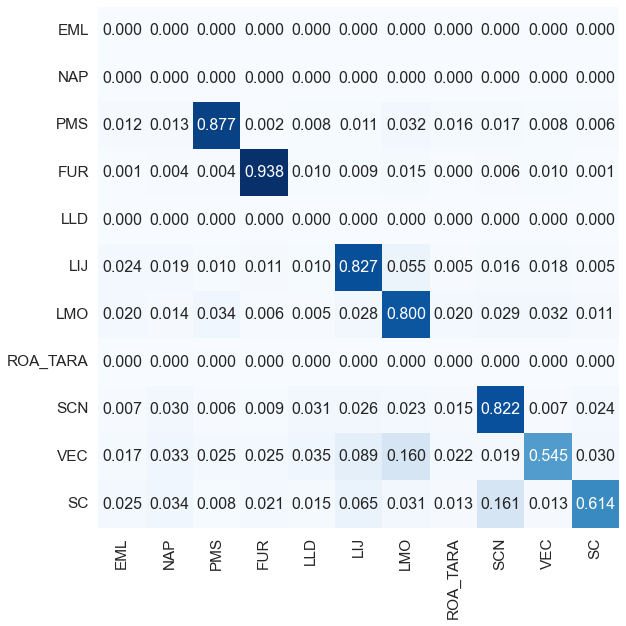

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize="true")

from utils import explain_label
df_cm = pd.DataFrame(cm, index = [explain_label(i) for i in range(0,11)],
                  columns = [explain_label(i) for i in range(0,11)])

plt.figure(figsize = (9, 9))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, 
            annot=True, 
            annot_kws={"size": 16}, 
            fmt='.3f', 
            cmap="Blues",
            cbar=False) 
plt.tight_layout()  

# plt.savefig('confusion.pdf')
plt.show()

In [25]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred, average=None)
for score, label in zip(f1, ['EML', 'NAP', 'PMS', 'FUR', 'LLD', 'LIJ', 'LMO', 'ROA_TARA', 'SCN', 'VEC','SC']):
    print(f"{label}: {score}")

EML: 0.0
NAP: 0.0
PMS: 0.8965221124946329
FUR: 0.918840579710145
LLD: 0.0
LIJ: 0.7516580692704495
LMO: 0.7746755800235942
ROA_TARA: 0.0
SCN: 0.8446274803444402
VEC: 0.6763672854992474
SC: 0.677456647398844
